In [90]:
# imports
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

In [91]:
Psi = pd.read_csv('../../dados_usados/psi.csv')

dados = pd.read_csv("../../dados_usados/dados").values

dados_datas = dados[:,1]
dados_casos = dados[:,2]
dados_mortes = dados[:,3]
dados_hospitalizados = dados[:,4]
dados_hospitalizados_vacinados = dados[:,5]
dados_infectados_vacinados = dados[:,6]
dados_vacinados_acumulados = dados[:,7]

In [92]:
# Facendo média móvel do PSI
copy = Psi.copy()
Psi = np.append(Psi, copy)
Psi = Psi

npd = len(Psi)
Nfo = 8

Psif = [[0]]*npd

for k in range(1, npd):
    if (k-Nfo) < 0 :
        Psif[k] = 1/k*sum(Psi[0:k])
    else:
        Psif[k] = 1/Nfo*sum(Psi[k-Nfo:k])

Psif.pop(0)

[0]

In [93]:
# Limpando dados de vacinados
vacinados_dados_aux =  np.copy(np.diff(dados_vacinados_acumulados))
# Diffs menores que 0 serão substituidos pela repetição do valor anterior, tornando todo valor igual ou maior que o anterior
for i in range(1,len(vacinados_dados_aux)):
    diff = vacinados_dados_aux[i] - vacinados_dados_aux[i-1]
    if diff < 0:
        vacinados_dados_aux[i-1] = vacinados_dados_aux[i]

novos_vacinados =  np.diff(vacinados_dados_aux)
novos_vacinados = novos_vacinados.tolist()
novos_vacinados.insert(0, 0)

In [94]:
# Ultima revisão: 05/01/2023
k = 1/4
gamma_a = 1/3.5
gamma_s = 1/4
gamma_h = 0.18
gamma_u = 0.13
mi_u = 0.4
qsi = 0.53 
h = 0.06
h_v = 0.012
mi_h = 0.15
ome_h = 0.14
ome_u = 0.29
delta = 0.31
p = 0.2

In [95]:
# def modelo 
def SEIIHURD(t, y, args):

    # t0, b0, t1, b1, t2, b2, t3, b3, t4, b4, t5, b5, b_else = args

    b0, b1, t0, t1 = args

    if t<20.178:
        beta=2.1317
    elif (t>=20.178-8) and (t < 72.94):
        beta=1.7645
    elif (t>=72.94) and (t < 148):
        beta=1.1281
    elif (t>=107.76354915) and (t < 149.34736536):
        beta=2.59807746
    elif(t >= 235.35360579 and t < t0):
        beta = 1.26315674
    elif (t >= t0 and t < t1):
        beta = b0
    elif (t >= t1):
        beta = b1
    else:
        beta=1

    beta_v = beta

    tau = novos_vacinados[int(t)]

    if t >= 321: # 321 é quando começa a vacina
        delta_av = 0.31
        delta_sv = 0.31
        phi_e = 0.7
        k_v=1/3
        p_v = 0.1
        gamma_av = 1/3.5
        gamma_sv = 1/4
        gamma_vu=0.26
        qsi_v = 0.99
        
        eps=.8

        mi_vh=0.03
        mi_vu=0.08
        gamma_vh=0.36
    else:
        delta_av = 0
        delta_sv = 0
        phi_e = 0
        k_v=0
        p_v = 0
        gamma_av = 0
        gamma_sv = 0
        gamma_vu=0
        qsi_v = 0
        eps=0
        mi_vh=0
        mi_vu=0
        gamma_vh=0

    N=14136417
    
    psi = Psif[int(t)]
    S=y[0]
    E=y[1]
    V=y[2]
    Sv=y[3]
    Ev=y[4]
    Ia=y[5]
    Is=y[6]
    Iav=y[7]
    Isv=y[8]
    H=y[9]
    Hv=y[10]
    U=y[11]
    Uv=y[12]
    R=y[13]
    Rv=y[14]
    D=y[15]
    Nw=y[16]
    NwV=y[17]
    NHn=y[18]
    NHnV=y[19]
    NIav=y[20]
    
    dSdt = (-(1-psi)*beta*S*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) - tau/N
    dEdt = ((1-psi)*beta*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv))*(S+V) - k*E
    dVdt = tau/N - phi_e*V - ((1-psi)*beta*V*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv))
    dSvdt =  phi_e*V - ((1-eps)*(1-psi)*beta_v*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) #- phi_e*eps*Sv
    dEvdt = ((1-eps)*(1-psi)*beta_v*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) - k_v*Ev
    dIadt = (1-p)*k*E - gamma_a*Ia
    dIsdt = p*k*E - gamma_s*Is
    dIavdt = (1-p_v)*k_v*Ev - gamma_av*Iav
    dIsvdt = p_v*k_v*Ev - gamma_sv*Isv   
    dHdt = h*qsi*gamma_s*Is + (1-mi_u+ome_u*mi_u)*gamma_u*U - gamma_h*H   
    dHvdt = h_v*qsi_v*gamma_sv*Isv + (1-mi_vu+ome_u*mi_vu)*gamma_vu*Uv - gamma_vh*Hv    
    dUdt = h*(1-qsi)*gamma_s*Is + ome_h*gamma_h*H - gamma_u*U
    dUvdt = h_v*(1-qsi_v)*gamma_sv*Isv + ome_h*gamma_vh*Hv - gamma_u*Uv
    dRdt = gamma_a*Ia + (1-h)*gamma_s*Is + (1-mi_h)*(1-ome_h)*gamma_h*H
    dRvdt = gamma_av*Iav + (1-h_v)*gamma_sv*Isv + (1-mi_vh)*(1-ome_h)*(gamma_vh*Hv)
    dDdt = (1-ome_h)*(mi_h*gamma_h*H +mi_vh*gamma_vh*Hv) + (1-ome_u)*(mi_u*gamma_u*U+mi_vu*gamma_vu*Uv)
    dNwdt = p*k*E 
    dNwVdt = tau/N
    dHndt = h*qsi*gamma_s*Is
    dHnvdt = h_v*qsi_v*gamma_sv*Isv 
    dNIAvdt = p_v*k_v*Ev

    return [dSdt, dEdt, dVdt, dSvdt, dEvdt, dIadt, dIsdt, dIavdt, dIsvdt, dHdt, dHvdt, dUdt, dUvdt, dRdt, 
            dRvdt, dDdt, dNwdt, dNwVdt, dHndt, dHnvdt, dNIAvdt]

In [96]:
# lq_SIR
def lq_SIR(pars, data, ts0, q0):

    b0, b1, t0, t1 = pars
    #parameters
    parode = b0, b1, t0, t1
    #calls integrator

    qs = solve_ivp(fun=SEIIHURD, t_span=[0, len(novos_vacinados)-1], args=(parode,) ,y0=q0, dense_output=True, method="RK45",  t_eval=np.arange(len(novos_vacinados)-2))
    qs = qs.y
    
    N=14873064

    mortos_modelo           = np.diff(qs[-6,:]*N).astype(float)
    casos_modelo            = np.diff(qs[-5,:]*N).astype(float)
    casos_vacinados_modelo  = np.diff(qs[-1,:]*N).astype(float)
    hosp_modelo             = np.diff(qs[-3,:]*N).astype(float)
    hospVac_modelo          = np.diff(qs[-2,:]*N).astype(float)

    novos_mortos            = np.diff(dados_mortes).astype(float)[:-3]
    novos_casos             = np.diff(dados_casos).astype(float)[:-3]
    novos_casos_vacinados   = np.diff(dados_infectados_vacinados).astype(float)[:-3]
    novos_hosp              = np.diff(dados_hospitalizados).astype(float)[:-3]
    novos_hosp_vac          = np.diff(dados_hospitalizados_vacinados).astype(float)[:-3]
    
    # casos = np.diff(qs[:, -2]*14930634)
    #define the standardized residuals
    errMortos = (mortos_modelo - novos_mortos) / np.sqrt(mortos_modelo+1)
    errCasos = (casos_modelo - novos_casos)/np.sqrt(casos_modelo+1)
    errCasosVacinados = (casos_vacinados_modelo - novos_casos_vacinados)/np.sqrt(casos_vacinados_modelo+1)
    errHosp = (hosp_modelo - novos_hosp) / np.sqrt(hosp_modelo+1)
    errHospVac = (hospVac_modelo - novos_hosp_vac) / np.sqrt(hospVac_modelo+1)
    return np.r_[errMortos, errCasos, errCasosVacinados, errHosp, errHospVac]


In [97]:
# Condições iniciais

N=14873064

D0          = 0
N0          = 14136417
R0          = 0
H0          = 0
HV0         = 0
U0          = 0
UV0         = 0
V0          = 0
Rv0         = 0
Is0         = 2.015439771376298e-06
Ia0         = 1.8028646508967777e-06
Iav0        = 1.8028646508967777e-06 
Isv0        = 1.8028646508967777e-06 
E0          = 1.7639153732952095e-06
Ev0         = 1.7639153732952095e-06
S0          = (1-Is0-Ia0-E0)
Sv0         = 0 
Nw0         = 0
NwV0        = 0

condicoes_iniciais = [S0,E0,V0, Sv0, Ev0, Ia0, Is0, Iav0, Isv0, H0, HV0, U0, UV0, R0, Rv0, D0, Nw0, NwV0, 0, 0, 0]

In [98]:
# Best Fit
def Best_Fit(data,n_tries, ts0, q0):

    # #DEEFINE THE INTERVALS OF PARS[0, 2.],[0, 2.], [0, 5.], [0, 5.],[0, 5.],[0, 80], [80, 170], [170, 240], [240, 400]  310
    intervals = np.array([[0, 5.], [0, 5.], [235.35360580, 400], [401, 628]])
    #NUMBER OF FITS
    #best error starts at inft 
    best_err = np.inf
    #aj the number of best fists 
    aj = 0
    for i in range(n_tries):
        if i%5 == 0:
            print(i)
            
        #create a set of parameters in the interval
        par0 = np.random.rand(len(intervals))
        par0 = intervals[:,0] + par0 * (intervals[:,1] - intervals[:,0])

        try:
            res = least_squares(lambda pars: lq_SIR(pars,data, ts0, q0), par0, bounds=(intervals[:,0], \
                                            intervals[:,1]))

            ier = res.status
            #if converges
            if ier >= 1 and ier <= 4:
                if res.cost < best_err:
                    #best_err = erro
                    best_err = res.cost
                    #best_pop = parametro
                    best_pop = res.x
                    #+1 best fit
                    aj = aj +1

                    print('achou',aj)
        except Exception as exp:
            print(exp)
            pass
                #in does not converge, do nothing

    return best_pop

In [99]:
#Run the minimizer

n_tries=100  #Quanto maior mais certeza do resultado. Colocar em 100 para roda com mais certeza (Ou até maiws se for necessário)
ts0 =  np.arange(len(novos_vacinados))


best_pop=Best_Fit(np.diff(dados_mortes), n_tries, ts0, condicoes_iniciais)
b0, b1, t0, t1 = best_pop
parode = [b0, b1, t0, t1]
# parode = [ 1.63607496,   3.40997039, 333.15303923, 439.95810453]

# TEMPO FOI OTIMIZADO TAMBÉM 

#parode = [  1.5864754 ,   3.5051942 , 317.72001799, 435.15640895]
# calls integrator
qs = solve_ivp(fun=SEIIHURD, t_span=[0, len(novos_vacinados)-1], args=(parode,) ,y0=condicoes_iniciais, dense_output=True, method="RK45",  t_eval=np.arange(len(novos_vacinados)-1))
qs = qs.y

0


/tmp/ipykernel_56742/220135833.py:30: RuntimeWarning: invalid value encountered in sqrt
  errCasosVacinados = (casos_vacinados_modelo - novos_casos_vacinados)/np.sqrt(casos_vacinados_modelo+1)


achou 1
5
achou 2
Residuals are not finite in the initial point.


/tmp/ipykernel_56742/220135833.py:29: RuntimeWarning: invalid value encountered in sqrt
  errCasos = (casos_modelo - novos_casos)/np.sqrt(casos_modelo+1)


10
15
achou 3
20
achou 4
Residuals are not finite in the initial point.
achou 5
25
30
35
40
45
Residuals are not finite in the initial point.
50
55
Residuals are not finite in the initial point.
60
Residuals are not finite in the initial point.
65
70
75
80
85
90
95


9129388.949972698


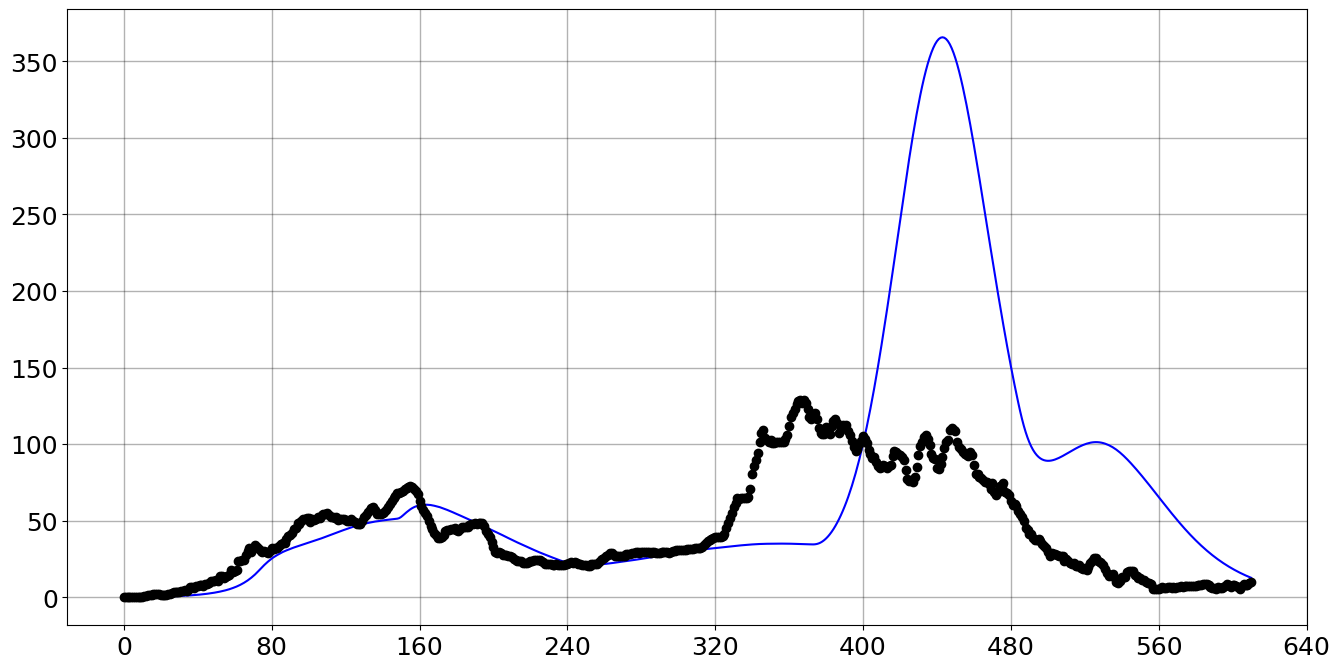

In [100]:
# plotando mortes
ts0 =  np.arange(len(novos_vacinados)-1)

qi = qs[-6,:] #mortes acumulados
errMortos = (qi - dados_mortes[:612]) / np.sqrt(qi+1)

    # mortos_modelo           = np.diff(qs[-6,:]*N)
    # casos_modelo            = np.diff(qs[-5,:]*N)
    # casos_vacinados_modelo   = np.diff(qs[-1,:]*N)
    # hosp_modelo             = np.diff(qs[-3,:]*N)
    # hospVac_modelo          = np.diff(qs[-2,:]*N)
#Criando plot
fig, ax = plt.subplots(figsize=(16,8))

#Desenhando grid no plot
ax.grid(which='major', axis='both', color='black',linewidth=1.,alpha=0.3)
ax.autoscale()

x_para_escala = np.arange(0, len(dados_datas)-3, 1)

ax.scatter(x_para_escala,  np.diff(dados_mortes)[:len(dados_datas)-3], color='black',zorder=3,label='Reported data')
#Plot the fitted function as a line.
ax.plot(x_para_escala, np.diff(N*qi)[:len(dados_datas)-3],color='blue',label='Fitted function')
#Set the labels
# ax.set_ylabel('Mortos',fontsize=22)
# ax.set_xlabel('Dias', fontsize=22)

#The size of the numbers on the axixis
ax.tick_params(labelsize=18)

#Limiting the ammount of dates on the X axixs
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
#Rotating the dates for better visualization
# plt.setp(ax.get_xticklabels(), rotation=30)
print( np.cumsum(N*qi)[-1])

#Show Graph       
plt.show()

547836834.0479032


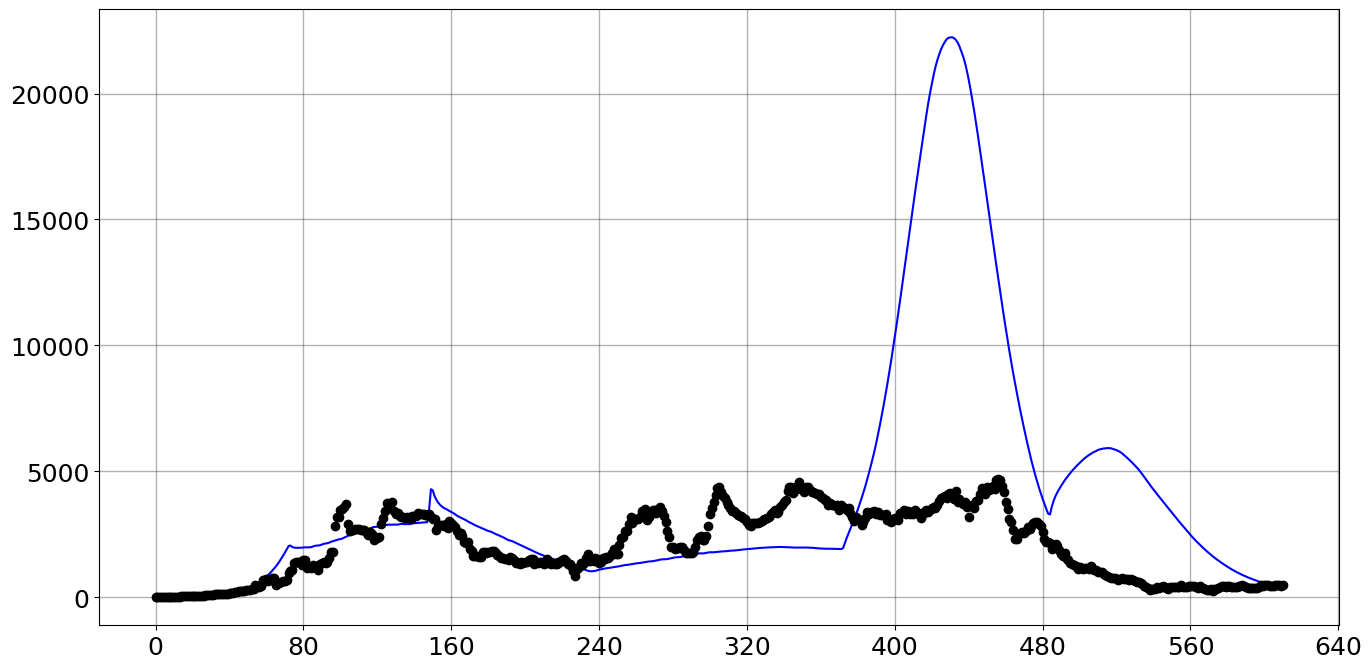

In [101]:
# plotando mortes
ts0 =  np.arange(len(novos_vacinados)-1)

qi = qs[-5,:] #mortes acumulados

    # mortos_modelo           = np.diff(qs[-6,:]*N)
    # casos_modelo            = np.diff(qs[-5,:]*N)
    # casos_vacinados_modelo   = np.diff(qs[-1,:]*N)
    # hosp_modelo             = np.diff(qs[-3,:]*N)
    # hospVac_modelo          = np.diff(qs[-2,:]*N)
#Criando plot
fig, ax = plt.subplots(figsize=(16,8))

#Desenhando grid no plot
ax.grid(which='major', axis='both', color='black',linewidth=1.,alpha=0.3)
ax.autoscale()

x_para_escala = np.arange(0, len(dados_datas)-3, 1)

ax.scatter(x_para_escala,  np.diff(dados_casos)[:len(dados_datas)-3], color='black',zorder=3,label='Reported data')
#Plot the fitted function as a line.
ax.plot(x_para_escala, np.diff(N*qi)[:len(dados_datas)-3],color='blue',label='Fitted function')
#Set the labels
# ax.set_ylabel('Mortos',fontsize=22)
# ax.set_xlabel('Dias', fontsize=22)

#The size of the numbers on the axixis
ax.tick_params(labelsize=18)

#Limiting the ammount of dates on the X axixs
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
#Rotating the dates for better visualization
# plt.setp(ax.get_xticklabels(), rotation=30)
print( np.cumsum(N*qi)[-1])

#Show Graph       
plt.show()

175655.407328792


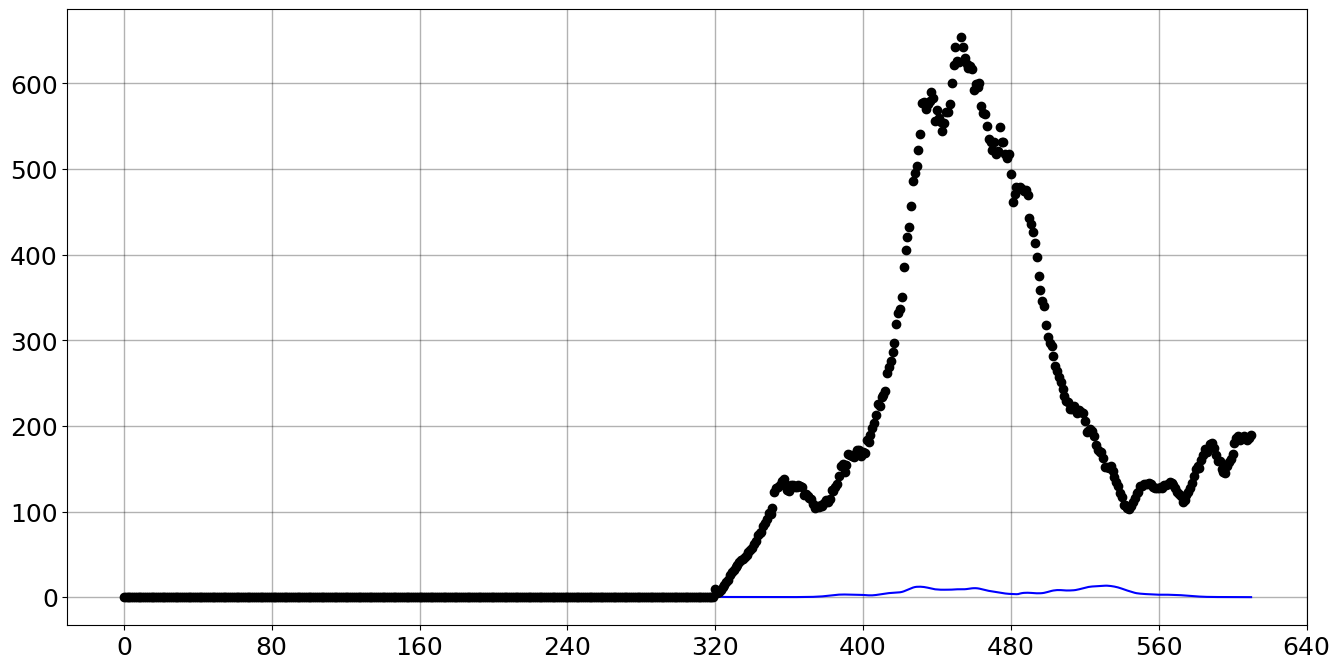

In [102]:
# plotando mortes
ts0 =  np.arange(len(novos_vacinados)-1)

qi = qs[-1,:] #mortes acumulados

    # mortos_modelo           = np.diff(qs[-6,:]*N)
    # casos_modelo            = np.diff(qs[-5,:]*N)
    # casos_vacinados_modelo   = np.diff(qs[-1,:]*N)
    # hosp_modelo             = np.diff(qs[-3,:]*N)
    # hospVac_modelo          = np.diff(qs[-2,:]*N)
#Criando plot
fig, ax = plt.subplots(figsize=(16,8))

#Desenhando grid no plot
ax.grid(which='major', axis='both', color='black',linewidth=1.,alpha=0.3)
ax.autoscale()

x_para_escala = np.arange(0, len(dados_datas)-3, 1)

ax.scatter(x_para_escala,  np.diff(dados_infectados_vacinados)[:len(dados_datas)-3], color='black',zorder=3,label='Reported data')
#Plot the fitted function as a line.
ax.plot(x_para_escala, np.diff(N*qi)[:len(dados_datas)],color='blue',label='Fitted function')
#Set the labels
# ax.set_ylabel('Mortos',fontsize=22)
# ax.set_xlabel('Dias', fontsize=22)

#The size of the numbers on the axixis
ax.tick_params(labelsize=18)

#Limiting the ammount of dates on the X axixs
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
#Rotating the dates for better visualization
# plt.setp(ax.get_xticklabels(), rotation=30)
print( np.cumsum(N*qi)[-1])

#Show Graph       
plt.show()

17113030.805430245


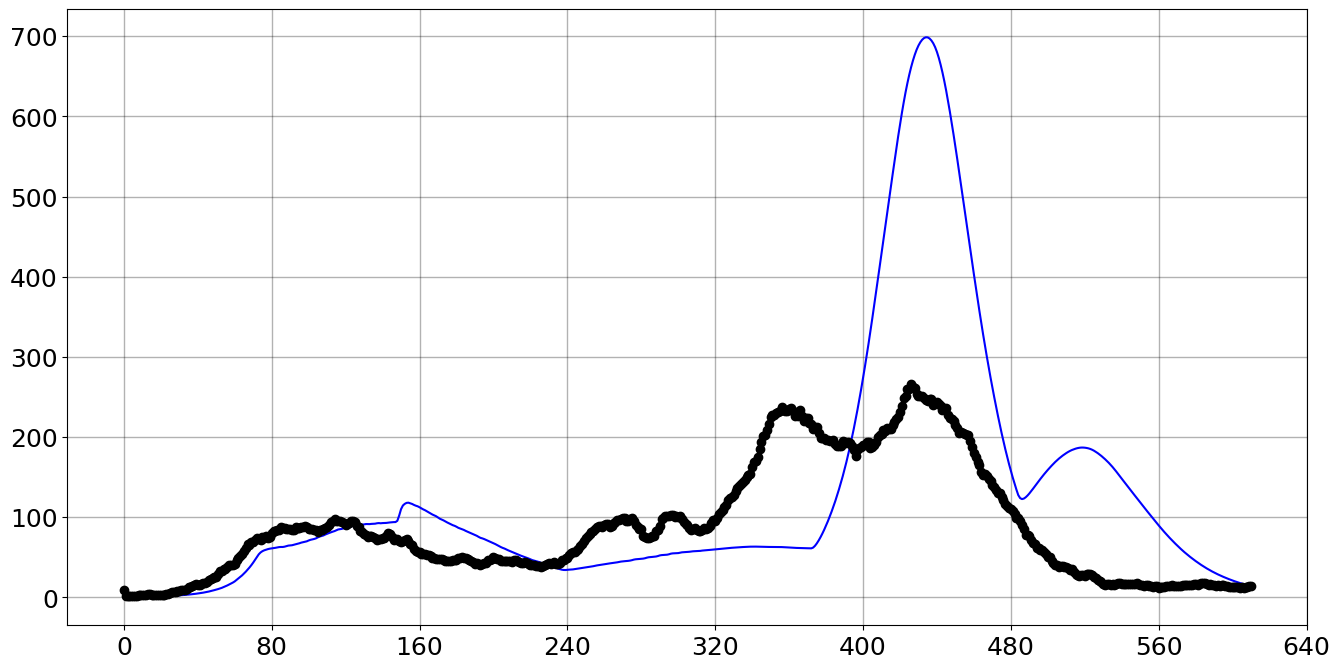

In [103]:
# plotando mortes
ts0 =  np.arange(len(novos_vacinados)-1)

qi = qs[-3,:] #mortes acumulados

    # mortos_modelo           = np.diff(qs[-6,:]*N)
    # casos_modelo            = np.diff(qs[-5,:]*N)
    # casos_vacinados_modelo   = np.diff(qs[-1,:]*N)
    # hosp_modelo             = np.diff(qs[-3,:]*N)
    # hospVac_modelo          = np.diff(qs[-2,:]*N)
#Criando plot
fig, ax = plt.subplots(figsize=(16,8))

#Desenhando grid no plot
ax.grid(which='major', axis='both', color='black',linewidth=1.,alpha=0.3)
ax.autoscale()

x_para_escala = np.arange(0, len(dados_datas)-3, 1)

ax.scatter(x_para_escala,  np.diff(dados_hospitalizados)[:len(dados_datas)-3], color='black',zorder=3,label='Reported data')
#Plot the fitted function as a line.
ax.plot(x_para_escala, np.diff(N*qi)[:len(dados_datas)-3],color='blue',label='Fitted function')
#Set the labels
# ax.set_ylabel('Mortos',fontsize=22)
# ax.set_xlabel('Dias', fontsize=22)

#The size of the numbers on the axixis
ax.tick_params(labelsize=18)

#Limiting the ammount of dates on the X axixs
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
#Rotating the dates for better visualization
# plt.setp(ax.get_xticklabels(), rotation=30)
print( np.cumsum(N*qi)[-1])

#Show Graph       
plt.show()

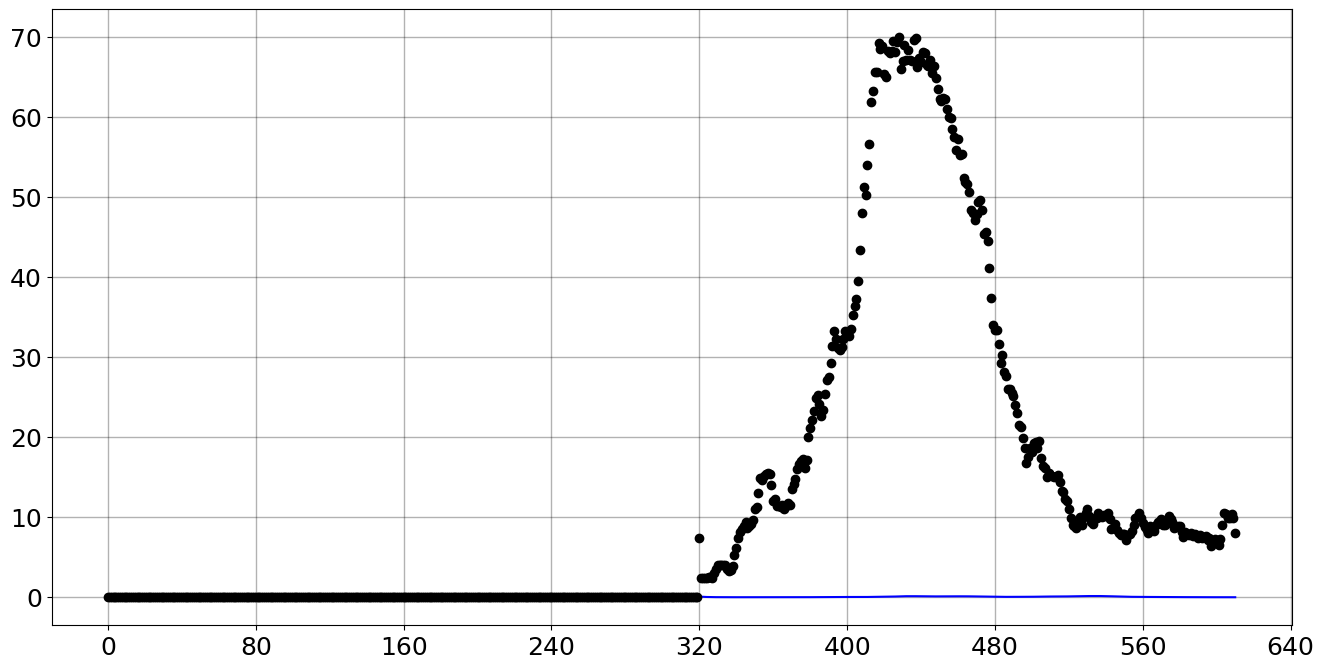

In [104]:
# plotando mortes
ts0 =  np.arange(len(novos_vacinados)-1)

qi = qs[-2,:] #mortes acumulados

    # mortos_modelo           = np.diff(qs[-6,:]*N)
    # casos_modelo            = np.diff(qs[-5,:]*N)
    # casos_vacinados_modelo   = np.diff(qs[-1,:]*N)
    # hosp_modelo             = np.diff(qs[-3,:]*N)
    # hospVac_modelo          = np.diff(qs[-2,:]*N)
#Criando plot
fig, ax = plt.subplots(figsize=(16,8))

#Desenhando grid no plot
ax.grid(which='major', axis='both', color='black',linewidth=1.,alpha=0.3)
ax.autoscale()

x_para_escala = np.arange(0, len(dados_datas)-3, 1)

ax.scatter(x_para_escala,  np.diff(dados_hospitalizados_vacinados)[:len(dados_datas)-3], color='black',zorder=3,label='Reported data')
#Plot the fitted function as a line.
ax.plot(x_para_escala, np.diff(N*qi)[:len(dados_datas)-3],color='blue',label='Fitted function')
#Set the labels
# ax.set_ylabel('Mortos',fontsize=22)
# ax.set_xlabel('Dias', fontsize=22)

#The size of the numbers on the axixis
ax.tick_params(labelsize=18)

#Limiting the ammount of dates on the X axixs
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
#Rotating the dates for better visualization
# plt.setp(ax.get_xticklabels(), rotation=30)

#Show Graph       
plt.show()

In [105]:
best_pop
#array([  1.5864754 ,   3.5051942 , 317.72001799, 435.15640895])

array([  1.97341342,   3.91870886, 372.18083577, 484.26665811])